# Simple GP regression


https://gpytorch.readthedocs.io/en/latest/examples/01_Simple_GP_Regression/Simple_GP_Regression.html




In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data


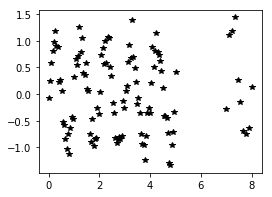

In [4]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.cat((torch.linspace(0, 5, 100), torch.linspace(7, 8, 10)))
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

In [5]:
train_x = train_x.to(device)
train_y = train_y.to(device)

## Model

Dans GPytorch, on fournit des outils pour construire rapidement un modèle. Contrairement aux autres packages, GPytorch ne fournit pas le modèle complet à l'utilisateur.

* GP model: `gpytorch.models.ExactGP` handles the inference
* Likelihood: `gpytorch.likelihoods.GaussianLikelihood` 
* Mean: prior mean, par exemple `gpytorch.means.ConstantMean()`
* Kernel: prior covariance, par exemple `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())`
* Multivariate Normal Distribution `gpytorch.distributions.MultivariateNormal`

In [6]:

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(train_x, train_y, likelihood).to(device)

## Train

In [7]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 1.111   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 1.081   lengthscale: 0.644   noise: 0.644
Iter 3/100 - Loss: 1.046   lengthscale: 0.598   noise: 0.598
Iter 4/100 - Loss: 1.007   lengthscale: 0.554   noise: 0.554
Iter 5/100 - Loss: 0.966   lengthscale: 0.513   noise: 0.513
Iter 6/100 - Loss: 0.924   lengthscale: 0.474   noise: 0.473
Iter 7/100 - Loss: 0.884   lengthscale: 0.437   noise: 0.436
Iter 8/100 - Loss: 0.847   lengthscale: 0.403   noise: 0.401
Iter 9/100 - Loss: 0.814   lengthscale: 0.372   noise: 0.369
Iter 10/100 - Loss: 0.785   lengthscale: 0.346   noise: 0.338
Iter 11/100 - Loss: 0.758   lengthscale: 0.323   noise: 0.310
Iter 12/100 - Loss: 0.733   lengthscale: 0.305   noise: 0.283
Iter 13/100 - Loss: 0.708   lengthscale: 0.291   noise: 0.259
Iter 14/100 - Loss: 0.682   lengthscale: 0.281   noise: 0.236
Iter 15/100 - Loss: 0.656   lengthscale: 0.275   noise: 0.215
Iter 16/100 - Loss: 0.628   lengthscale: 0.272   noise: 0.196
Iter 17/100 - Los

## Eval

confidence region is 2 sigma

In [8]:

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 10, 51).to(device)
    observed_pred = likelihood(model(test_x))

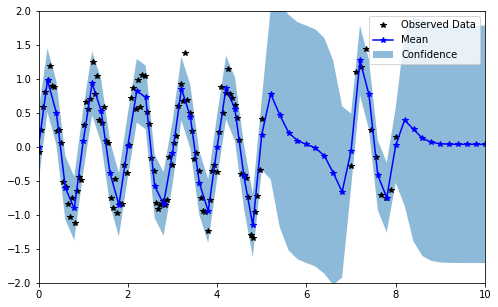

In [9]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b*-')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-2, 2])
    ax.set_xlim([0, 10])

    ax.legend(['Observed Data', 'Mean', 'Confidence'])